Numeric columns for anomaly detection: Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Number of potential outliers (Z-score): 65
Number of potential outliers (Isolation Forest): 45


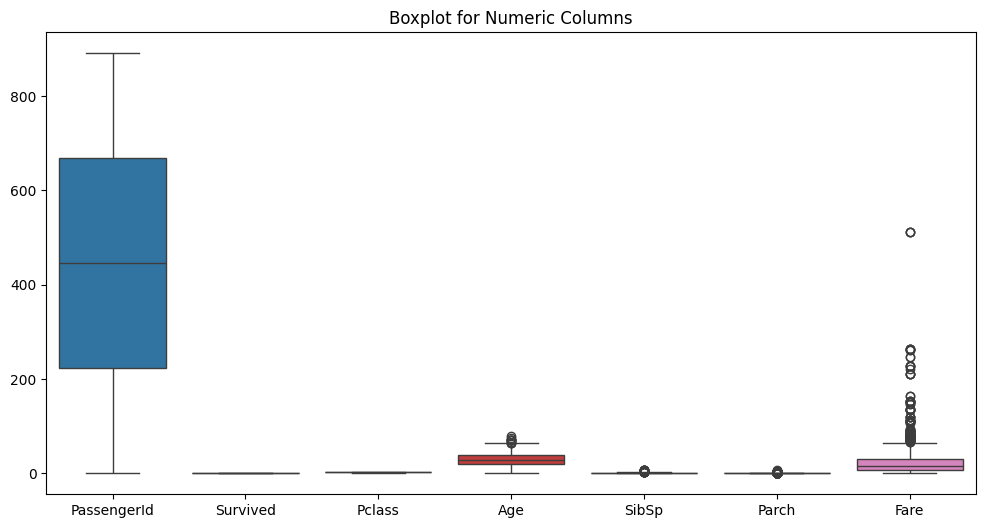

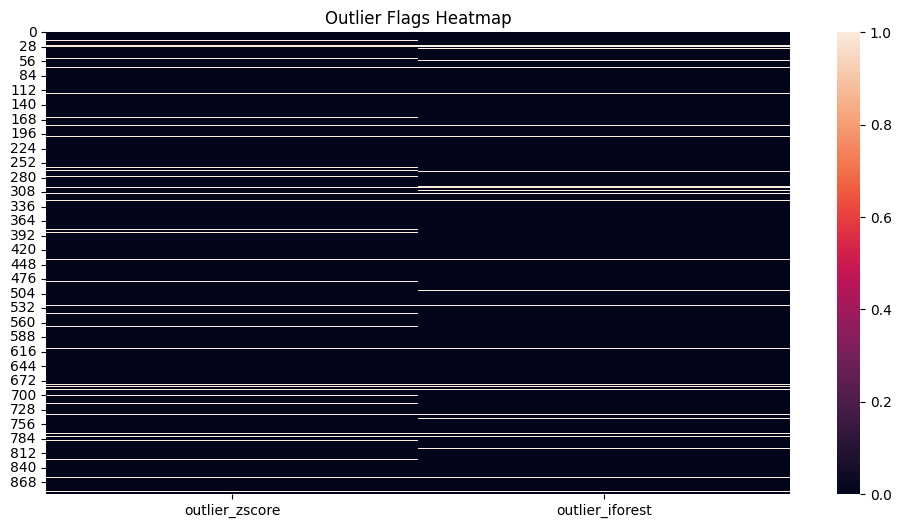

Anomaly flags saved to ../data/metadata/anomaly_flags.csv


c:\Users\Antra Tiwari\OneDrive\Desktop\Autonomous data cleaning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 7)           │           231 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,671 (53.40 KB)

 Trainable params: 13,671 (53.40 KB)

 Non-trainable params: 0 (0.00 B)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Number of potential outliers (LSTM autoencoder): 45


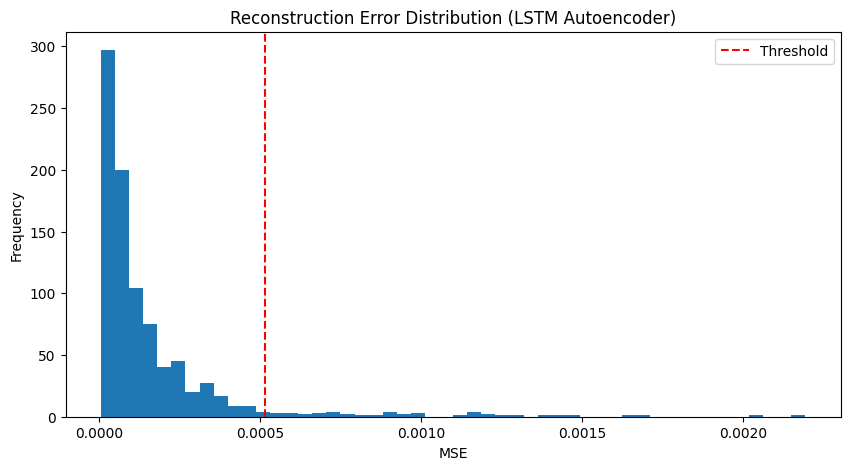

Merged metadata saved to ../data/metadata/merged_metadata.csv


In [3]:
# Day 2: Anomaly Detection
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------
# Step 0: Set paths
# -----------------------------
cleaned_data_path = "../data/cleaned/dirty_dataset.csv"
anomaly_output_path = "../reports/anomaly_report.txt"
os.makedirs(os.path.dirname(anomaly_output_path), exist_ok=True)

# -----------------------------
# Step 1: Load dataset
# -----------------------------
df = pd.read_csv(cleaned_data_path)
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"Numeric columns for anomaly detection: {numeric_cols}")

# -----------------------------
# Step 2: Detect outliers using Z-score (simple statistical method)
# -----------------------------
z_scores = np.abs(stats.zscore(df[numeric_cols].fillna(0)))
df["outlier_zscore"] = (z_scores > 3).any(axis=1).astype(int)
print(f"Number of potential outliers (Z-score): {df['outlier_zscore'].sum()}")

# -----------------------------
# Step 3: Detect outliers using Isolation Forest
# -----------------------------
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df["outlier_iforest"] = iso_forest.fit_predict(df[numeric_cols].fillna(0))
# IsolationForest returns -1 for outliers, 1 for normal
df["outlier_iforest"] = df["outlier_iforest"].apply(lambda x: 1 if x==-1 else 0)
print(f"Number of potential outliers (Isolation Forest): {df['outlier_iforest'].sum()}")

# -----------------------------
# Step 4: Visualize outliers
# -----------------------------
plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot for Numeric Columns")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df[["outlier_zscore", "outlier_iforest"]], cbar=True)
plt.title("Outlier Flags Heatmap")
plt.show()

# -----------------------------
# Step 5: Save anomaly flags
# -----------------------------
anomaly_output_path_csv = "../data/metadata/anomaly_flags.csv"
os.makedirs(os.path.dirname(anomaly_output_path_csv), exist_ok=True)
df[["PassengerId", "outlier_zscore", "outlier_iforest"]].to_csv(anomaly_output_path_csv, index=False)
print(f"Anomaly flags saved to {anomaly_output_path_csv}")

# -----------------------------
# Step 6: Save report
# -----------------------------
with open(anomaly_output_path, 'w') as f:
    f.write("Anomaly Detection Report\n")
    f.write("======================\n\n")
    f.write(f"Z-score outliers: {df['outlier_zscore'].sum()}\n")
    f.write(f"Isolation Forest outliers: {df['outlier_iforest'].sum()}\n")

    # -----------------------------
# Step 7: LSTM Autoencoder for numeric sequences
# -----------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler

# Prepare numeric data
data = df[numeric_cols].fillna(0).values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# LSTM expects 3D input: (samples, timesteps, features)
# Here, each row is treated as a "sequence" of features
data_scaled = data_scaled.reshape((data_scaled.shape[0], 1, data_scaled.shape[1]))

# Build LSTM Autoencoder
timesteps = data_scaled.shape[1]
features = data_scaled.shape[2]

model = Sequential([
    LSTM(32, activation='relu', input_shape=(timesteps, features), return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train autoencoder
history = model.fit(data_scaled, data_scaled, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Predict and calculate reconstruction error
pred = model.predict(data_scaled)
mse = np.mean(np.power(data_scaled - pred, 2), axis=(1,2))
threshold = np.percentile(mse, 95)  # 95th percentile as anomaly threshold
df['outlier_lstm'] = (mse > threshold).astype(int)

print(f"Number of potential outliers (LSTM autoencoder): {df['outlier_lstm'].sum()}")

# Save updated anomaly flags
df[['PassengerId', 'outlier_zscore', 'outlier_iforest', 'outlier_lstm']].to_csv(
    "../data/metadata/anomaly_flags.csv", index=False
)

# Visualize reconstruction error
plt.figure(figsize=(10,5))
plt.hist(mse, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution (LSTM Autoencoder)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -----------------------------
# Step 8: Merge anomaly flags with ground truth
# -----------------------------
ground_truth_path = "../data/metadata/ground_truth_metadata.csv"
anomaly_flags_path = "../data/metadata/anomaly_flags.csv"
merged_path = "../data/metadata/merged_metadata.csv"

# Load both
gt_df = pd.read_csv(ground_truth_path)
af_df = pd.read_csv(anomaly_flags_path)

# Merge on PassengerId
merged_df = gt_df.merge(af_df, on="PassengerId", how="left")

# Save merged metadata
merged_df.to_csv(merged_path, index=False)
print(f"Merged metadata saved to {merged_path}")


